# CA3

Group 37

Kaggle name: 
* zertez - Marcus D. Figenschou

Group members: 
* Jannicke Ådalen
* Marcus Dalaker Figenschou
* Rikke Sellevold Vegstein

### Imports

In [18]:
# Import packages
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

### Import and read data

In [2]:
# Set working directory, we are using both macbook and windows laptops and one of our computers
# Is using local jupyter kernel, so we had to set this up in order for it to find the correct folder
if "CA3" in os.getcwd():
    os.chdir("..")  # Go up one level if we're in CA3

print(f"Working directory now: {os.getcwd()}")

# Create path to training and test data
train_path = os.path.join("CA3", "assets", "train.csv")
test_path = os.path.join("CA3", "assets", "test.csv")

# Load data
# 1. Load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Working directory now: /Users/marcusdalakerfigenschou/Documents/NMBU/DAT200


### Data exploration and visualisation

In [3]:
# Checking for NaNs
print("---Train Data Info---")
train_df.info()

print("---Test Data Info---")
test_df.info()

---Train Data Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            2800 non-null   float64
 1   Weight          2800 non-null   float64
 2   Sweetness       2800 non-null   float64
 3   Softness        2800 non-null   float64
 4   HarvestTime     2800 non-null   float64
 5   Ripeness        2800 non-null   float64
 6   Acidity         2800 non-null   float64
 7   Peel Thickness  2800 non-null   float64
 8   Banana Density  2800 non-null   float64
 9   Quality         2800 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 218.9 KB
---Test Data Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            1200 non-null   float64
 1   Weight      

There are two unwanted features peel thickness and banana density, must remove these both from the train and test dataset

In [4]:
# Remove unwanted features so that the visualisation of features in the raw data are comparable
train_df = train_df.drop(columns=["Peel Thickness", "Banana Density"], axis=1)
test_df = test_df.drop(columns=["Peel Thickness", "Banana Density"], axis=1)

Checking the new data

In [5]:
print("---Train Data Info---")
train_df.info()

print("---Test Data Info---")
test_df.info()

---Train Data Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         2800 non-null   float64
 1   Weight       2800 non-null   float64
 2   Sweetness    2800 non-null   float64
 3   Softness     2800 non-null   float64
 4   HarvestTime  2800 non-null   float64
 5   Ripeness     2800 non-null   float64
 6   Acidity      2800 non-null   float64
 7   Quality      2800 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 175.1 KB
---Test Data Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         1200 non-null   float64
 1   Weight       1200 non-null   float64
 2   Sweetness    1200 non-null   float64
 3   Softness     1200 non-null   float64
 4   HarvestTime  120

Since the dataset is quite large with 2800 samples we chose to go for boxplot and histograms to visualize the data. Boxplots are excellent to get a quick view of the percentile distribution and to check for outliers. Histograms are excellent to check if the data is roughly normally distributed or skewed. We could have maybe done som data extraction to get a lower n sample and plot this, but we chose this method instead since its descriptive enough.

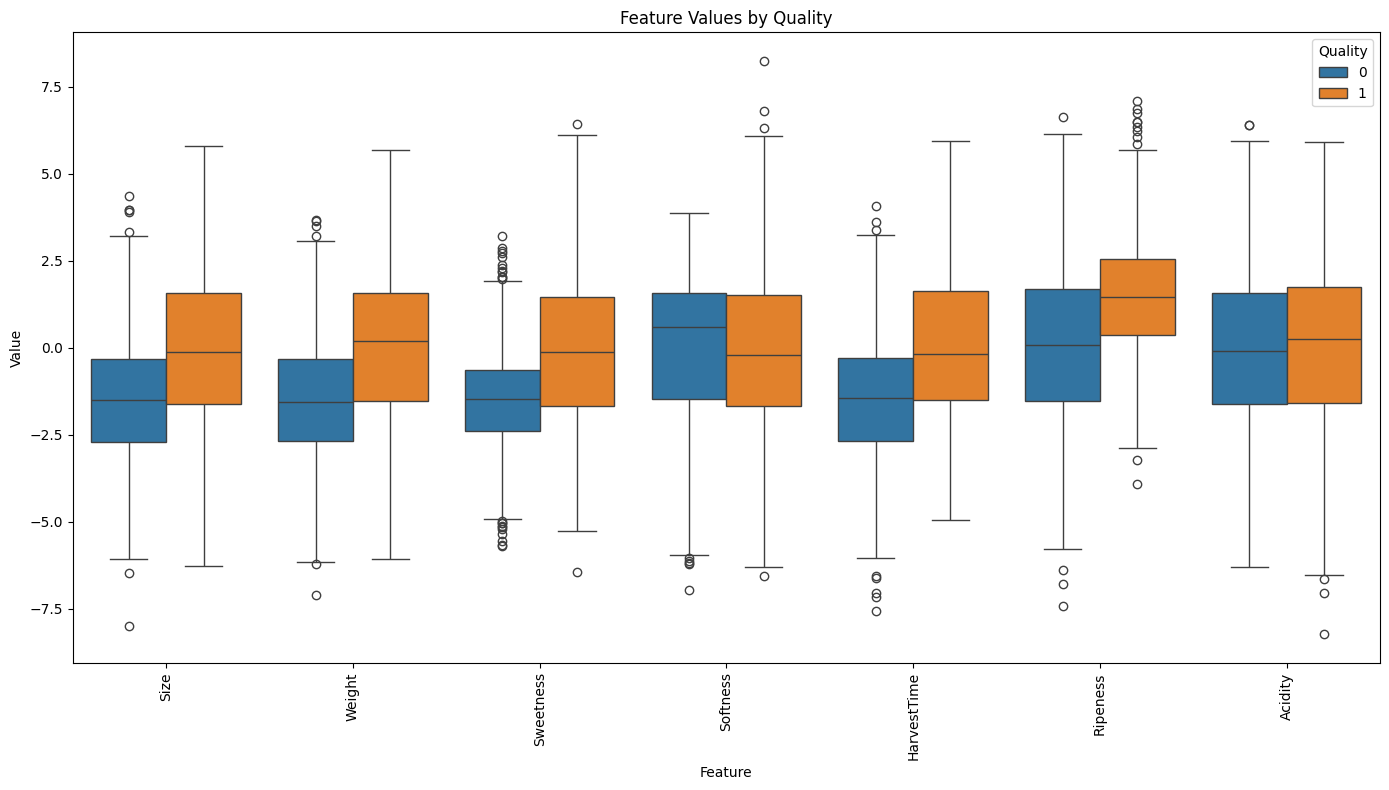

In [6]:
# Boxplot of raw data
# Drop 'Quality' feature as this is the target label
features = train_df.columns.drop("Quality")
melted_df = pd.melt(
    train_df,
    id_vars=["Quality"],
    value_vars=features,
    var_name="Feature",
    value_name="Value",
)

plt.figure(figsize=(14, 8))
sns.boxplot(x="Feature", y="Value", hue="Quality", data=melted_df)
plt.xticks(rotation=90)
plt.title("Feature Values by Quality")
plt.tight_layout()
plt.show()

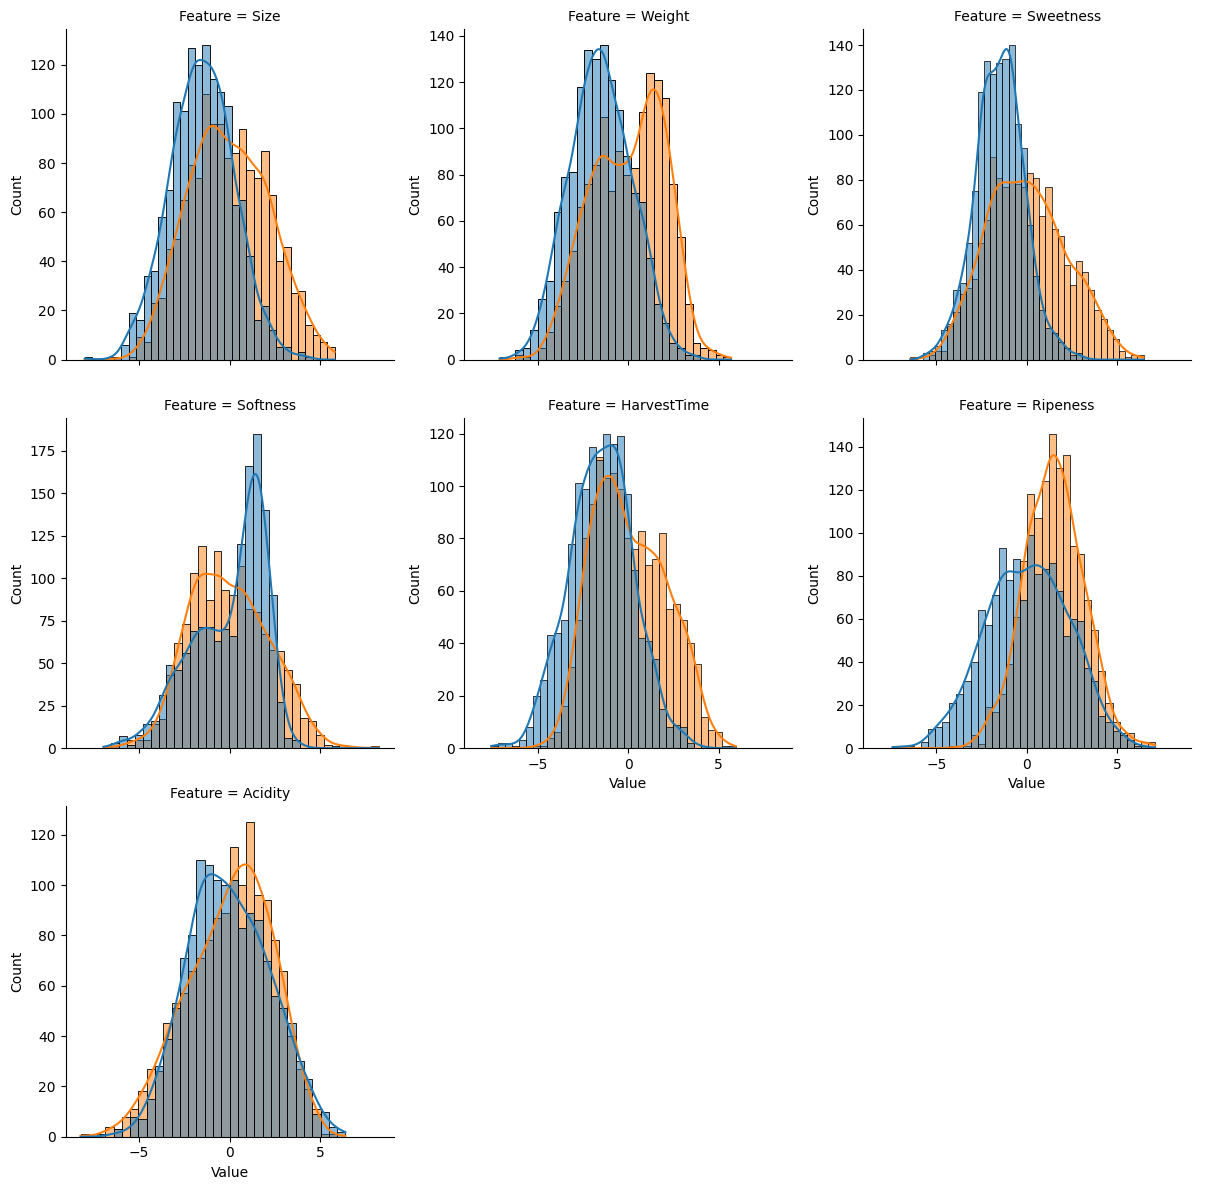

In [7]:
# Histogram of raw data
# Create FacetGrid where histograms of features will be plotted

g = sns.FacetGrid(melted_df, col="Feature", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.histplot, x="Value", hue="Quality", kde=True)
g.add_legend()
plt.tight_layout()
plt.show()

## Conclusions from the data exploration and visualisation

From the boxplot we can see that there are several outliers in the dataset, especially for sweetness quality 0, harvesttime quality 0, and ripeness quality 1. There are a few outliers in size quality 0, and weight quality 0. This indicates that values for bad bananas are typically more extreme than than values for good bananas. Based on this we did outlier removal using z score > 3

From the histplot:

Weight, softness show two peaks. This shows that the data has a bimodal distribution. This means that the data has two distinct clusters within the overall distribution. This means that for weight and softness, the distribution is spread more widely between good quality bananas and bad quality bananas. This is interesting since no other features show such a clear distinction. This might indicate that size and weight are the most reliable indicators for distinguishing between good and bad quality bananas. Ripeness, acidity and size are skewd to the right. Sweetness and softness are skewed to the left. Whereas size, weight and harvesttime are roughly normally distributed


### Data cleaning

In [8]:
# Calculate z-scores and remove outliers from training data
# Remove outliers separately for each quality group
train_df_clean = train_df.copy()
removed_rows = 0

# For each feature
for feature in [col for col in train_df.columns if col != "Quality"]:
    for quality in [0, 1]:
        # Calculate z-scores for this feature within this quality group
        data = train_df_clean[train_df_clean["Quality"] == quality][feature]
        mean = data.mean()
        std = data.std()

        # Consider points beyond z-score threshold as outliers (typically using 3)
        z_score_threshold = 3

        # Find rows to remove - those with absolute z-score greater than threshold
        outlier_mask = (train_df_clean["Quality"] == quality) & (
            abs((train_df_clean[feature] - mean) / std) > z_score_threshold
        )

        # Remove these rows
        rows_before = len(train_df_clean)
        train_df_clean = train_df_clean[~outlier_mask]
        removed = rows_before - len(train_df_clean)
        removed_rows += removed
        print(f"Removed {removed} outliers for {feature} (Quality {quality})")

print(f"Total rows removed: {removed_rows}")

Removed 5 outliers for Size (Quality 0)
Removed 0 outliers for Size (Quality 1)
Removed 3 outliers for Weight (Quality 0)
Removed 1 outliers for Weight (Quality 1)
Removed 8 outliers for Sweetness (Quality 0)
Removed 0 outliers for Sweetness (Quality 1)
Removed 5 outliers for Softness (Quality 0)
Removed 3 outliers for Softness (Quality 1)
Removed 3 outliers for HarvestTime (Quality 0)
Removed 0 outliers for HarvestTime (Quality 1)
Removed 1 outliers for Ripeness (Quality 0)
Removed 6 outliers for Ripeness (Quality 1)
Removed 0 outliers for Acidity (Quality 0)
Removed 2 outliers for Acidity (Quality 1)
Total rows removed: 37


### Data processing after cleanup

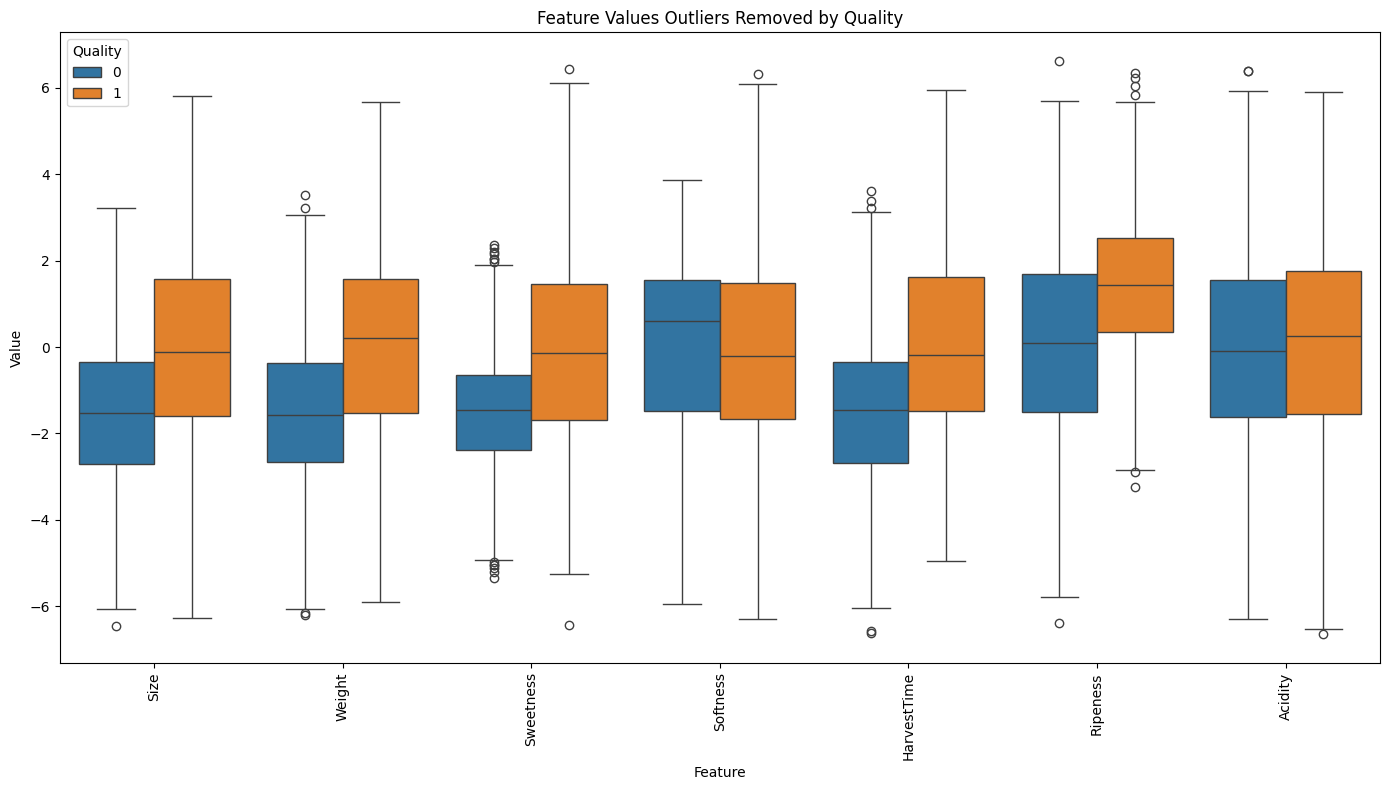

In [9]:
# Checking boxplot first

features_clean = train_df_clean.columns.drop("Quality")
melted_clean_df = pd.melt(
    train_df_clean,
    id_vars=["Quality"],
    value_vars=features_clean,
    var_name="Feature",
    value_name="Value",
)

plt.figure(figsize=(14, 8))
sns.boxplot(x="Feature", y="Value", hue="Quality", data=melted_clean_df)
plt.xticks(rotation=90)
plt.title("Feature Values Outliers Removed by Quality")
plt.tight_layout()
plt.show()

It looks a bit beter there are still some outliers left, but increasing the threshold can be too risky.

## Creating feature correlation matrix for feature engineering

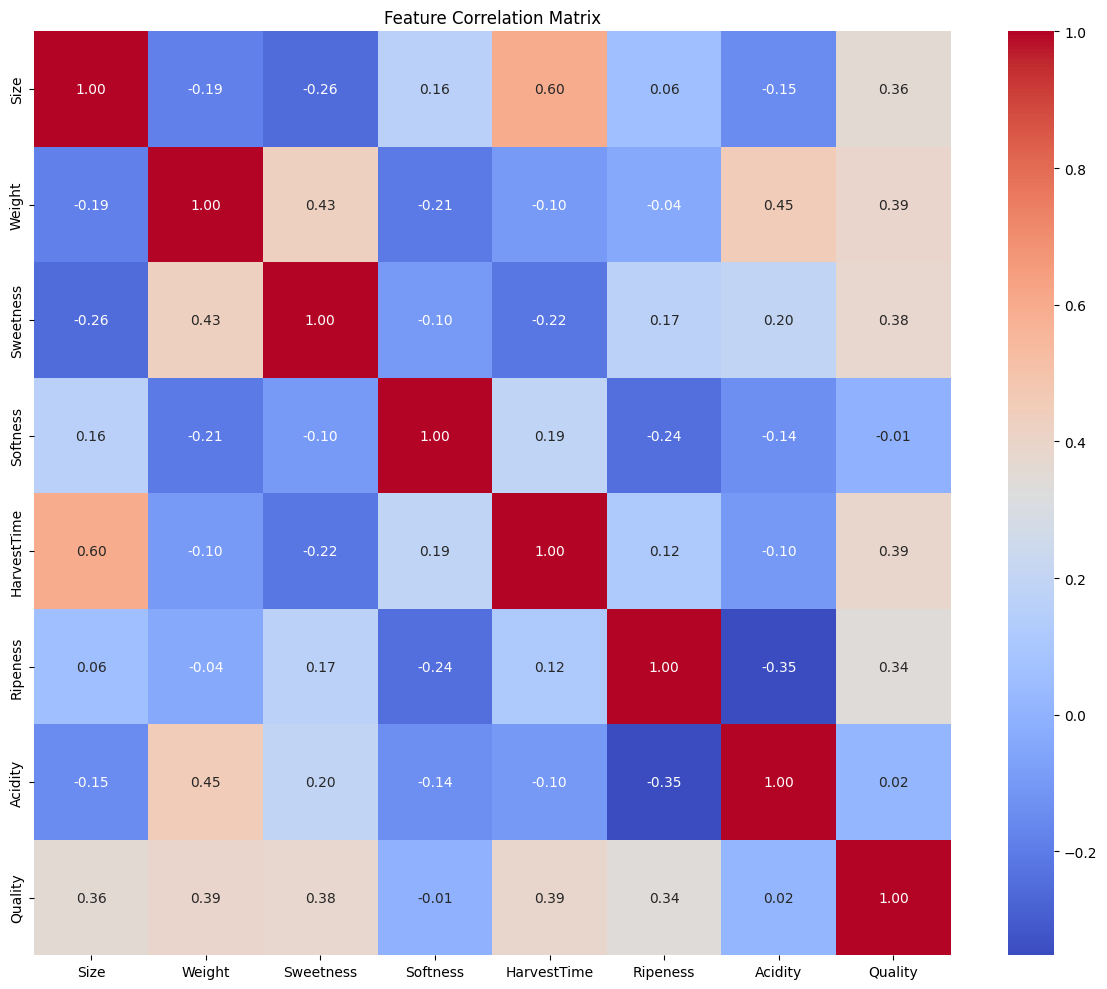

In [10]:
# Creating correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = train_df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [11]:
# Creating interaction terms based on correlation matrix

# Interaction terms for train data
train_df_clean["Weight_Sweetness"] = (
    train_df_clean["Weight"] * train_df_clean["Sweetness"]
)
train_df_clean["Size_HarvestTime"] = (
    train_df_clean["Size"] * train_df_clean["HarvestTime"]
)
train_df_clean["Sweetness_HarvestTime"] = (
    train_df_clean["Sweetness"] * train_df_clean["HarvestTime"]
)
train_df_clean["Size_Sweetness"] = train_df_clean["Size"] * train_df_clean["Sweetness"]
train_df_clean["Weight_Acidity"] = train_df_clean["Weight"] * train_df_clean["Acidity"]
train_df_clean["Ripeness_Acidity"] = (
    train_df_clean["Ripeness"] * train_df_clean["Acidity"]
)

# Interaction terms for test data
test_df["Weight_Sweetness"] = test_df["Weight"] * test_df["Sweetness"]
test_df["Size_HarvestTime"] = test_df["Size"] * test_df["HarvestTime"]
test_df["Sweetness_HarvestTime"] = test_df["Sweetness"] * test_df["HarvestTime"]
test_df["Size_Sweetness"] = test_df["Size"] * test_df["Sweetness"]
test_df["Weight_Acidity"] = test_df["Weight"] * test_df["Acidity"]
test_df["Ripeness_Acidity"] = test_df["Ripeness"] * test_df["Acidity"]

## Create train validation data

In [12]:
# Split into features and target
X = train_df_clean.drop(columns=["Quality"])
y = train_df_clean["Quality"]

# %% Scale the features initially
scaler_initial = StandardScaler()
X_scaled = scaler_initial.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)  # Keep column names

# Create an initial feature selection split
X_train_sfs, X_val_sfs, y_train_sfs, y_val_sfs = train_test_split(
    X_scaled_df, y, test_size=0.20, random_state=42, stratify=y
)

### Modelling

Since we are predicting the categorical value 0 and 1 for bananas, we should be using logistic regression, randomforest, svc or other nonlinearmodels. We tested out multiple models and ended up with svc with the rbf kernel as the best option

In [13]:
# 3. Parameter tuning with multiple train_test_split operations and integrated feature selection
# Define parameters to test for SVM

# Parameter tuning with feature selection
C_values = [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10]
gamma_values = ["scale", 0.05, 0.01, 0.005]
kernel_types = ["rbf"]
random_states = range(1, 11)  # 10 random states

Parameters were first choesn logistically then we narrowed it down manually, this was the fastest way to find a range of good C values and gamma values.
We are doing 10 train/val datasets, this is alternative to cross validation.

We are using forward selection in order to find the most relevant features.

In [14]:
# Track all results and best results
results = []
best_score = 0
best_params = {}
best_features = []
best_scaler = None
best_model = None

for kernel in kernel_types:
    for C in C_values:
        for gamma in gamma_values:
            # Create a base model with current parameters
            base_model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
            sfs = SequentialFeatureSelector(
                estimator=base_model,
                # setting this to auto so that it find the best parameters. This needs the tol attribute as well
                n_features_to_select="auto",
                direction="forward",
                scoring="accuracy",
                # Tol is set to 0.1% which is a threshold for adding new features
                tol=0.001,
                n_jobs=-1,
                cv=None,
            )
            # Fit feature selector
            sfs.fit(X_train_sfs, y_train_sfs)
            # Get selected features
            selected_features = X.columns[sfs.get_support()].tolist()
            # Skip if no features selected
            if len(selected_features) == 0:
                continue

            # Evaluate with multiple train/test splits
            combo_scores = []
            for rs in random_states:
                X_train, X_val, y_train, y_val = train_test_split(
                    X[selected_features], y, test_size=0.20, random_state=rs, stratify=y
                )
                # Scale the data specifically for this split
                scaler_split = StandardScaler()
                X_train_scaled = scaler_split.fit_transform(X_train)
                X_val_scaled = scaler_split.transform(X_val)
                # Train model
                model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
                model.fit(X_train_scaled, y_train)
                # Evaluate
                y_val_pred = model.predict(X_val_scaled)
                score = accuracy_score(y_val, y_val_pred)
                combo_scores.append(score)
            # Average score across splits
            avg_score = np.mean(combo_scores)
            std_score = np.std(combo_scores)
            # Store result for this combination
            results.append(
                {
                    "kernel": kernel,
                    "C": C,
                    "gamma": gamma,
                    "n_features": len(selected_features),
                    "features": selected_features,
                    "avg_score": avg_score,
                    "std_score": std_score,
                }
            )
            # Update if better
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"kernel": kernel, "C": C, "gamma": gamma}
                best_features = selected_features.copy()
                # Create the best scaler with all training data
                best_scaler = StandardScaler()
                X_best = X[best_features]
                X_best_scaled = best_scaler.fit_transform(X_best)
                # Train the best model on all data
                best_model = SVC(**best_params)
                best_model.fit(X_best_scaled, y)

In [15]:
# Display top results
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values("avg_score", ascending=False)
    pd.set_option("display.max_columns", None)
    print("\n----- Top 10 Results -----")
    print(
        results_df[
            ["kernel", "C", "gamma", "n_features", "avg_score", "std_score"]
        ].head(10)
    )

# %% Display best parameters
print("\n----- Best Parameters -----")
print(f"Kernel: {best_params.get('kernel')}")
print(f"C: {best_params.get('C')}")
print(f"Gamma: {best_params.get('gamma')}")
print(f"Number of features: {len(best_features)}")
print(f"Selected features: {best_features}")
print(f"Best validation score: {best_score:.4f}")


----- Top 10 Results -----
   kernel     C  gamma  n_features  avg_score  std_score
16    rbf   5.0  scale           9   0.983002   0.004660
17    rbf   5.0   0.05          10   0.981555   0.004108
21    rbf   7.0   0.05          10   0.981193   0.003895
8     rbf   3.0  scale           9   0.981013   0.003053
20    rbf   7.0  scale           9   0.980651   0.004206
28    rbf   9.0  scale           9   0.980470   0.003945
24    rbf   8.0  scale           9   0.980289   0.004314
32    rbf  10.0  scale          10   0.979928   0.003999
12    rbf   4.0  scale           8   0.979747   0.003412
9     rbf   3.0   0.05          11   0.979747   0.004560

----- Best Parameters -----
Kernel: rbf
C: 5.0
Gamma: scale
Number of features: 9
Selected features: ['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness', 'Acidity', 'Sweetness_HarvestTime', 'Ripeness_Acidity']
Best validation score: 0.9830


### Final evaluation

In [16]:
# Train final model on entire train set
X_train_final = X[best_features]
X_train_final_scaled = best_scaler.transform(X_train_final)
y_train_pred = best_model.predict(X_train_final_scaled)


# %% Process test data
X_test_selected = test_df[best_features]
X_test_selected_scaled = best_scaler.transform(X_test_selected)

# Make predictions
y_pred = best_model.predict(X_test_selected_scaled)

### Kaggle submission

In [17]:
# 6. Saving predictions for Kaggle submission
y_pred_df = pd.DataFrame(y_pred, columns=["Quality"])
y_pred_df.index.name = "ID"
filename = f"submission_svc_k{best_params['kernel']}_C{best_params['C']}_g{best_params['gamma']}.csv"
y_pred_df[["Quality"]].to_csv(filename)

print(f"Saved submission to {filename}")

Saved submission to submission_svc_krbf_C5.0_gscale.csv


This gave us a score on kaggle of 0.98541. Our best score achieved is 0.98906 but we are sadly unable to reproduce this score.